In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
import random

We'll take a displacement and give a reward drawn from a bernoulli distribution with mean (success probability of beta + dolinar's guessing rule, which is maximum likelihood)

In [10]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def ps_maxlik(beta):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    p=0
    for n1 in [0,1]:
       p+=Prob(np.sign(beta)*(-1)**(n1)*alpha, beta, n1)
    return p/2


Text(0, 0.5, '$P_s\\; ( \\beta )$')

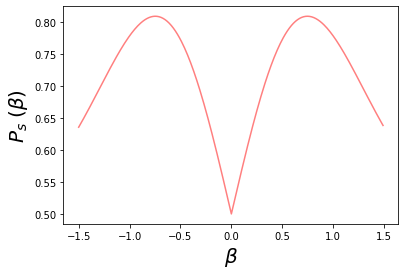

In [97]:
betas = np.arange(-1.5,1.5,.01)
plt.plot(betas,[ps_maxlik(b) for b in betas],alpha=0.5,c="red")
plt.xlabel(r'$\beta$', size=20)
plt.ylabel(r'$P_s\; ( \beta )$', size=20)

Now let's create a dataset; the idea is to sample a reward many times for a given beta.

In [11]:

def createdataset(number_rews_per_beta=10**2):
    dataset = []
    labels=[]
    global betas_train
    global number_of_samples
    number_of_samples = number_rews_per_beta
    betas_train = np.arange(-1.5,1.5,.1)
    for i in range(len(betas_train)):
        beta = betas_train[i]
        
        for k in range(number_rews_per_beta):
                    
            mean_bernoulli = ps_maxlik(beta)
            reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
            
            dataset.append([beta, reward])
    return np.array(dataset)

We can plot the data obtained, it's noisy!

Obviously, the more you sample the less noisy the average is!

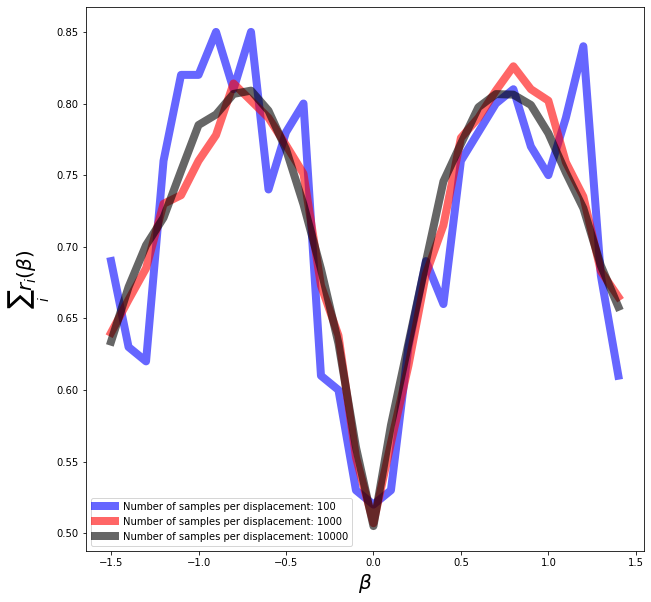

In [106]:
colors = ["blue", "red","black"]
plt.figure(figsize=(10,10))
for index,number_of_samples in enumerate([10**2, 10**3, 10**4]):

    data = createdataset(number_of_samples)
    data = np.split(data, len(betas_train))
    avg=[]
    for k in data:
        avg.append(np.mean(k[:,1]))
    avg=np.array(avg)
    plt.plot(betas_train, avg, c=colors[index], alpha=0.6, linewidth=8,label="Number of samples per displacement: " + str(number_of_samples))

plt.xlabel(r'$\beta$', size=20)
plt.ylabel(r'$\sum_i r_i( \beta )$', size=20)
plt.legend()

Now we want to train a network, as defined in the class Net(), to learn this function over stochastic rewards

In [218]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(1,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


If we feed the network

In [166]:
data = createdataset(10**2)
data = np.split(data, len(betas_train))
net = Net()
inp = np.expand_dims(data[0][:,0],axis=1)
print("output network before training: ", net(inp)[:5])
print(" ")
print("what it should be: ", ps_maxlik(data[0][:,0])[:5])

output network before training:  tf.Tensor(
[[0.0019488]
 [0.0019488]
 [0.0019488]
 [0.0019488]
 [0.0019488]], shape=(5, 1), dtype=float64)
 
what it should be:  [0.63557272 0.63557272 0.63557272 0.63557272 0.63557272]


In [221]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

length_training = 100

dataset = createdataset(10**3)
dataset = np.split(dataset, len(betas_train))
net = Net()
inp = np.expand_dims(data[0][:,0],axis=1)

histo_preds = {} #here i save the predictions

for epoch in range(length_training):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for batch in dataset:
        with tf.GradientTape() as tape:
            tape.watch(net.trainable_variables)
            betas_input = np.expand_dims(batch[:,0],axis=1)
            preds = net(betas_input)
            rews = np.expand_dims(batch[:,1],axis=1)
            loss = tf.keras.losses.MSE(preds, rews)
            loss = tf.reduce_mean(loss)

            grads = tape.gradient(loss, net.trainable_variables)
            optimizer.apply_gradients(zip(grads, net.trainable_variables))
        epoch_loss_avg(loss)
    if epoch % 5 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
        pred_beta_train = net(np.expand_dims(betas_train,axis=1))
        histo_preds[str(epoch)] = {"values": pred_beta_train, "epoch_number": epoch}



Epoch 000: Loss: 0.247
Epoch 005: Loss: 0.203
Epoch 010: Loss: 0.203
Epoch 015: Loss: 0.203
Epoch 020: Loss: 0.203
Epoch 025: Loss: 0.203
Epoch 030: Loss: 0.202
Epoch 035: Loss: 0.202
Epoch 040: Loss: 0.202
Epoch 045: Loss: 0.201
Epoch 050: Loss: 0.201
Epoch 055: Loss: 0.200
Epoch 060: Loss: 0.199
Epoch 065: Loss: 0.198
Epoch 070: Loss: 0.198
Epoch 075: Loss: 0.197
Epoch 080: Loss: 0.197
Epoch 085: Loss: 0.196
Epoch 090: Loss: 0.197
Epoch 095: Loss: 0.196


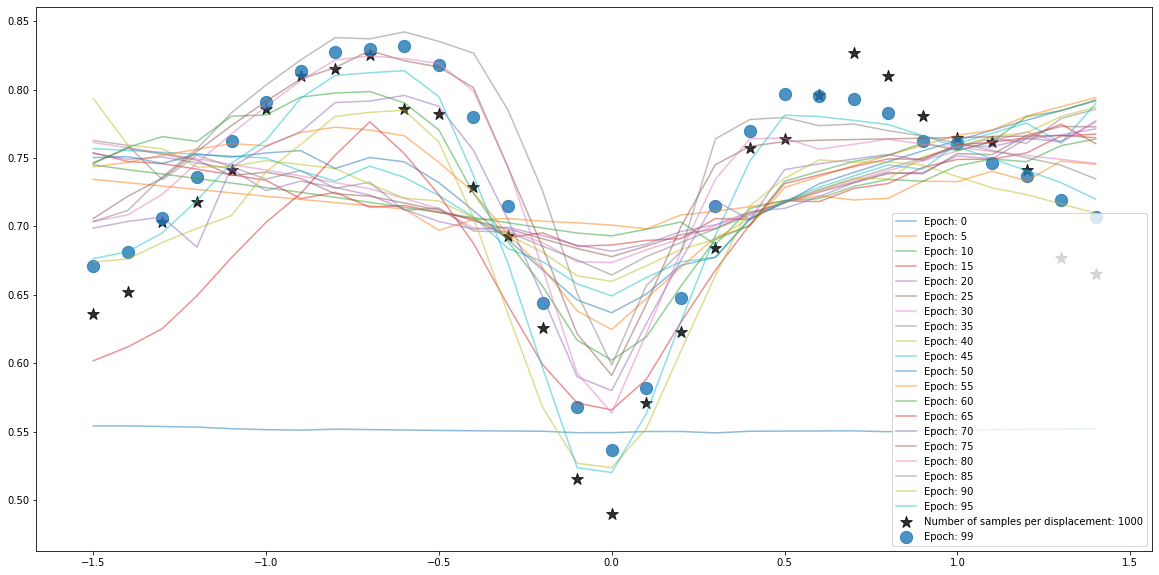

In [238]:
plt.figure(figsize=(20,10))
#plt.plot(betas_train, [ps_maxlik(b) for b in betas_train], '--',color="black", label="True value")

avg=[]
for k in dataset:
    avg.append(np.mean(k[:,1]))
avg=np.array(avg)

plt.scatter(betas_train, avg, marker="*", c=colors[index], alpha=0.8, s=150,label="Number of samples per displacement: " + str(number_of_samples))
plt.plot(betas_train, avg, c=colors[index], linewidth=5, alpha=0.8)

for j in histo_preds.values():
    plt.plot(betas_train, np.squeeze(j["values"]), alpha=0.5, label="Epoch: "+str(j["epoch_number"]))
    
plt.scatter(betas_train, np.squeeze(net(np.expand_dims(betas_train,axis=1))), s=150, alpha=0.8,label="Epoch: "+str(epoch))

plt.legend()


It kind of works! As a sanity check, let's see what happens if we feed with much more info (more rewards per beta).

Epoch 000: Loss: 0.253
Epoch 010: Loss: 0.202
Epoch 020: Loss: 0.202
Epoch 030: Loss: 0.202
Epoch 040: Loss: 0.202
Epoch 050: Loss: 0.201
Epoch 060: Loss: 0.201
Epoch 070: Loss: 0.200
Epoch 080: Loss: 0.199
Epoch 090: Loss: 0.198


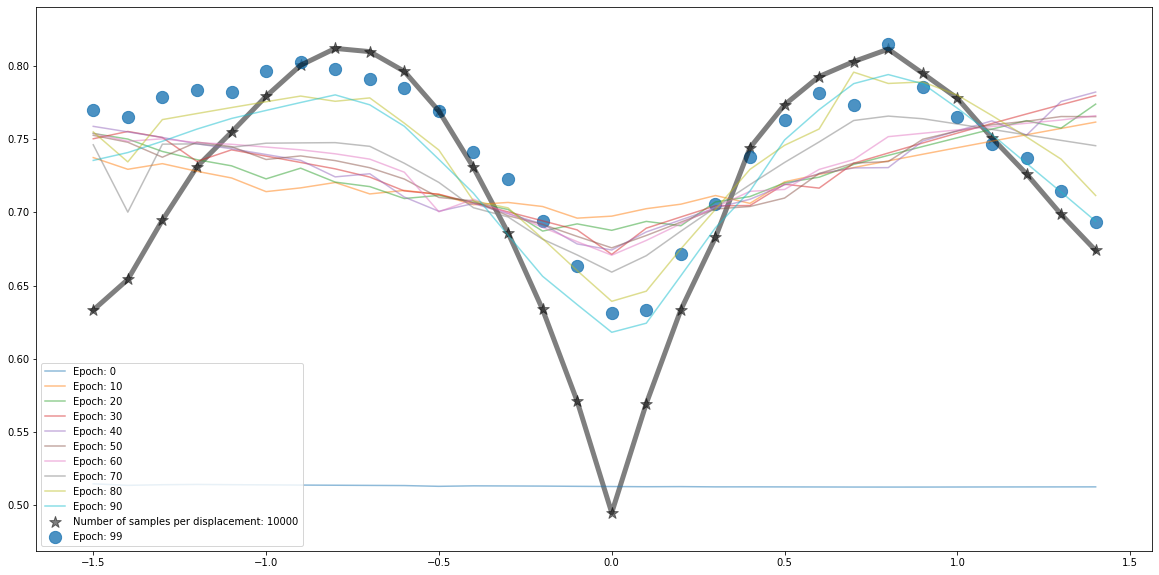

In [248]:
def learning_problem(rews_per_beta, length_training):
    optimizer = tf.keras.optimizers.Adam(lr=0.001)

    global dataset, net
    dataset = createdataset(rews_per_beta)
    dataset = np.split(dataset, len(betas_train))
    net = Net()
    inp = np.expand_dims(data[0][:,0],axis=1)

    histo_preds = {} #here i save the predictions

    for epoch in range(length_training):
        epoch_loss_avg = tf.keras.metrics.Mean()

        for batch in dataset:
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                betas_input = np.expand_dims(batch[:,0],axis=1)
                preds = net(betas_input)
                rews = np.expand_dims(batch[:,1],axis=1)
                loss = tf.keras.losses.MSE(preds, rews)
                loss = tf.reduce_mean(loss)

                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
            epoch_loss_avg(loss)
        if epoch % int(length_training/10) == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
            pred_beta_train = net(np.expand_dims(betas_train,axis=1))
            histo_preds[str(epoch)] = {"values": pred_beta_train, "epoch_number": epoch}

    plt.figure(figsize=(20,10))
    #plt.plot(betas_train, [ps_maxlik(b) for b in betas_train], '--',color="black", label="True value")

    avg=[]
    for k in dataset:
        avg.append(np.mean(k[:,1]))
    avg=np.array(avg)

    plt.scatter(betas_train, avg, marker="*", c=colors[index], alpha=0.5, s=150,label="Number of samples per displacement: " + str(number_of_samples))
    plt.plot(betas_train, avg, c=colors[index], linewidth=5, alpha=0.5)

    for j in histo_preds.values():
        plt.plot(betas_train, np.squeeze(j["values"]), alpha=0.5, label="Epoch: "+str(j["epoch_number"]))

    plt.scatter(betas_train, np.squeeze(net(np.expand_dims(betas_train,axis=1))), s=150, alpha=0.8,label="Epoch: "+str(epoch))

    plt.legend()

learning_problem(10**4,100)

** Comment **: it does not improve the predictions, but any serious statement has to be done after averaging the data, so forget it for now. Better results are shown in the following!

### Now that we are convinced we can learn the mean value of a (parametrized) distibution from noisy data, let's see how this get affected if we shuffle the data points (each batch is comoposed from different values of displacements).###

\\



### Notice also that the results are even **better**!###

Epoch 000: Loss: 0.235
Epoch 010: Loss: 0.199
Epoch 020: Loss: 0.195
Epoch 030: Loss: 0.194
Epoch 040: Loss: 0.193
Epoch 050: Loss: 0.193
Epoch 060: Loss: 0.193
Epoch 070: Loss: 0.193
Epoch 080: Loss: 0.193
Epoch 090: Loss: 0.193


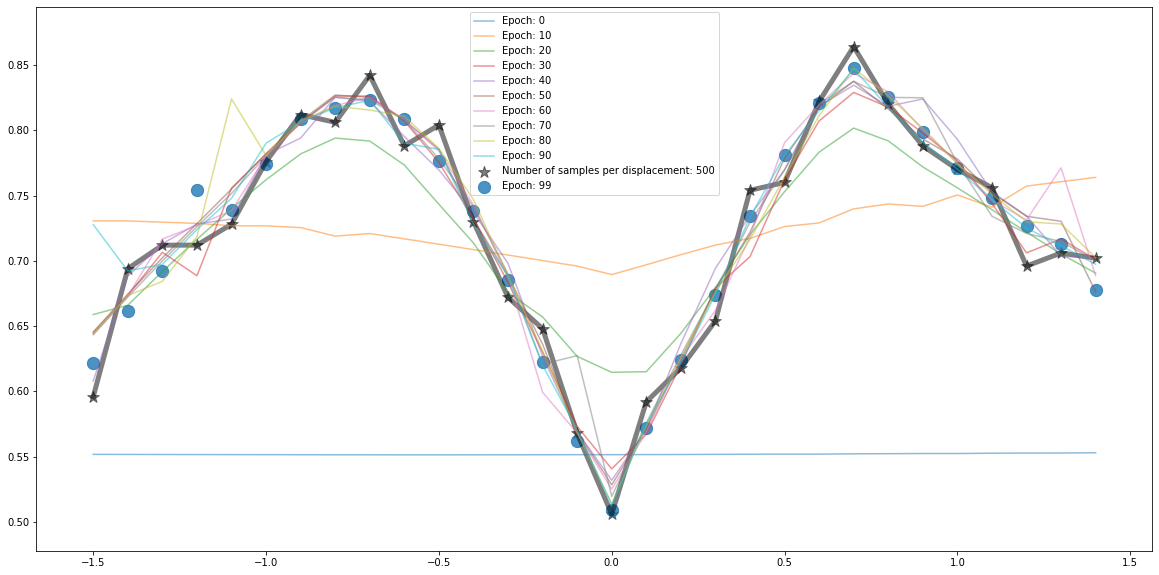

In [274]:
def learning_problem(rews_per_beta, length_training, number_splits=10):
    optimizer = tf.keras.optimizers.Adam(lr=0.001)

    global dataset, net
    dataset = createdataset(rews_per_beta)
    dataset_copy = dataset.copy()
    np.random.shuffle(dataset)
    dataset = np.split(dataset, number_splits + len(dataset)%number_splits)
    net = Net()
    inp = np.expand_dims(data[0][:,0],axis=1)

    histo_preds = {} #here i save the predictions

    for epoch in range(length_training):
        epoch_loss_avg = tf.keras.metrics.Mean()

        for batch in dataset:
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                betas_input = np.expand_dims(batch[:,0],axis=1)
                preds = net(betas_input)
                rews = np.expand_dims(batch[:,1],axis=1)
                loss = tf.keras.losses.MSE(preds, rews)
                loss = tf.reduce_mean(loss)

                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
            epoch_loss_avg(loss)
        if epoch % int(length_training/10) == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
            pred_beta_train = net(np.expand_dims(betas_train,axis=1))
            histo_preds[str(epoch)] = {"values": pred_beta_train, "epoch_number": epoch}

    plt.figure(figsize=(20,10))
    #plt.plot(betas_train, [ps_maxlik(b) for b in betas_train], '--',color="black", label="True value")

    avg=[]
    dataset_copy = np.split(dataset_copy, len(betas_train))
    for k in dataset_copy:
        avg.append(np.mean(k[:,1]))
    avg=np.array(avg)

    plt.scatter(betas_train, avg, marker="*", c=colors[index], alpha=0.5, s=150,label="Number of samples per displacement: " + str(number_of_samples))
    plt.plot(betas_train, avg, c=colors[index], linewidth=5, alpha=0.5)

    for j in histo_preds.values():
        plt.plot(betas_train, np.squeeze(j["values"]), alpha=0.5, label="Epoch: "+str(j["epoch_number"]))

    plt.scatter(betas_train, np.squeeze(net(np.expand_dims(betas_train,axis=1))), s=150, alpha=0.8,label="Epoch: "+str(epoch))

    plt.legend()

learning_problem(500,100, number_splits=15) #The desired batch_size can be easily obtained as Batch_size*Splits = len(dataset), in this case is Batch_size = 100 bacuase
#the lenght of dataset is len(betas_train)*rewards_per_beta. We took len(betas_train) = 30; so len(dataset) = 15000

This is good! Open question: how much sampling do you need to accurately estimate the function? Does the network perform a better generalization than just connecting the dots with a straight line? (this effect could be better appreciated if we had less betas). Maybe it's nice to study; I think it's related with contextual bandit problem. It would be nice to study how to relate this with the regret, and for this some reference would be section "non-linear bandits" of the following work: https://www.microsoft.com/en-us/research/wp-content/uploads/2017/01/SurveyBCB12.pdf

It may also be interesting to adapt TS with linear bandits to the nonlinear case:
https://courses.cs.washington.edu/courses/cse599i/18wi/resources/lecture9/lecture9.pdf